# Prediction of the "classification" label 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel, RobertaModel, RobertaTokenizer, ViTModel, BlipProcessor, BlipForQuestionAnswering , CLIPProcessor, CLIPModel, get_linear_schedule_with_warmup, AutoModelForSequenceClassification, AutoModelForImageClassification, AutoImageProcessor
from transformers import BeitImageProcessor, BeitForImageClassification
import pickle 
import torch.nn as nn
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.nn import CrossEntropyLoss
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [ ]:
df_combined = pd.read_csv('df_combined.csv')
df_combined

In [ ]:
def get_model_save_location(model_path):
    parts = model_path.split('/', 1)  # Split at the first "/" encountered
    return parts[1] if len(parts) > 1 else model_path

def get_multimodal_model_save_location(nlp_model_path, image_model_path, operation):
    nlp_parts = nlp_model_path.split('/', 1)
    nlp_tmp = nlp_parts[1] if len(nlp_parts) > 1 else nlp_model_path
    image_parts = image_model_path.split('/', 1)
    image_tmp = image_parts[1] if len(image_parts) > 1 else image_model_path
    return f"{nlp_tmp}_{image_tmp}_{operation}"

def save_model_path(model_name):
    return f"./trained_models/{model_name}.pt"

def save_predictions_path(model_name):
    return f"./trained_results/{model_name}.csv"

## NLP prediction

https://huggingface.co/BAAI/bge-reranker-large

## Version 3

In [ ]:
# Create a PyTorch dataset
class ClassifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.to_numpy()
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len        

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create data loaders
def create_data_loader(texts, labels, tokenizer, max_len, batch_size):
    ds = ClassifierDataset(
        texts=texts,
        labels=labels,
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

class NLPClassifier(nn.Module):
    def __init__(self, n_classes, pretrained_model_base):
        super(NLPClassifier, self).__init__()
        self.nlp_model = pretrained_model_base
        self.text_pooling = nn.AdaptiveAvgPool1d(1)
        self.drop = nn.Dropout(p=0.3)
        self.hidden = nn.Linear(self.nlp_model.config.hidden_size, 128)  # Change 128 to your desired hidden layer size
        self.out = nn.Linear(128, n_classes)

    def forward(self, input_ids, attention_mask):
        text_output = self.nlp_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # text_pooled_output = text_output.last_hidden_state[:, 0, :]
        text_pooled_output = self.text_pooling(text_output.last_hidden_state.transpose(1, 2)).view(-1, self.nlp_model.config.hidden_size)
        
        output = self.drop(text_pooled_output)
        output = nn.ReLU()(self.hidden(output))
        # return self.out(output)
        return torch.nn.functional.log_softmax(self.out(output), dim=1)

In [ ]:
multimodal = False

# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# model_path = 'roberta-base'
# model_path = 'BAAI/bge-reranker-large'
model_path = 'facebook/bart-large-cnn'
# model_path = 'google/bigbird-pegasus-large-arxiv'

tokenizer = AutoTokenizer.from_pretrained(model_path)
base_model = AutoModel.from_pretrained(model_path).to(device)

data_subset = df_combined#[:50]

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(data_subset['classification_by_editorial'])

# Split data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(data_subset['text'], encoded_labels, test_size=0.2, random_state=42)
# test_texts, val_texts, test_labels, val_labels = train_test_split(test_texts, test_labels, test_size=0.5, random_state=42) # change test_size for the first to 0.3 

BATCH_SIZE = 100  # maximum for BGE is ~116
MAX_LEN = 256

train_data_loader = create_data_loader(train_texts, train_labels, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_texts, test_labels, tokenizer, MAX_LEN, BATCH_SIZE)
# val_data_loader = create_data_loader(val_texts, val_labels, tokenizer, MAX_LEN, BATCH_SIZE)

# Initialize the classifier and optimizer
model = NLPClassifier(len(le.classes_), base_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss

# Define the loss function
loss_fn = CrossEntropyLoss().to(device)

# Define the number of training epochs
EPOCHS = 5

train_losses = []
test_losses = []

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

for epoch in range(EPOCHS):
    print(f'STARTING Epoch {epoch + 1}/{EPOCHS}')
    model.train()
    total_loss = 0

    for batch in tqdm(train_data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        model.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_data_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_loss = 0

    # for batch in tqdm(val_data_loader):
    for batch in tqdm(test_data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask)

        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

    avg_test_loss = total_loss / len(test_data_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}")

# Plotting the training and testing losses
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend()
plt.show()

# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in tqdm(test_data_loader):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)

    _, preds = torch.max(outputs, 1)
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

text_predictions = predictions    
    
# Save model:
torch.save(model.state_dict(), save_model_path(get_model_save_location(model_path)))

In [ ]:
accuracy = accuracy_score(true_labels, text_predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(le.inverse_transform(true_labels), le.inverse_transform(text_predictions), digits=4))

# Confusion Matrix
cm = confusion_matrix(true_labels, text_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

5 epochs with Roberta model:

```
Accuracy: 0.9855475128561332
Classification Report:
                       precision    recall  f1-score   support

      left_wing_in_US     0.9555    0.9765    0.9659      3958
 left_wing_outside_US     0.9908    0.9891    0.9900     17133
     right_wing_in_US     0.9572    0.9340    0.9455      2441
right_wing_outside_US     0.9912    0.9913    0.9913     17499

             accuracy                         0.9855     41031
            macro avg     0.9737    0.9727    0.9731     41031
         weighted avg     0.9856    0.9855    0.9855     41031
```

5 epochs with BGE-Reranker large

```
Accuracy: 0.9708269357315201
Classification Report:
                       precision    recall  f1-score   support

      left_wing_in_US     0.9189    0.9442    0.9313      3958
 left_wing_outside_US     0.9764    0.9849    0.9806     17133
     right_wing_in_US     0.9066    0.8632    0.8844      2441
right_wing_outside_US     0.9860    0.9781    0.9820     17499

             accuracy                         0.9708     41031
            macro avg     0.9470    0.9426    0.9446     41031
         weighted avg     0.9708    0.9708    0.9708     41031
```

5 epochs with BART-large-CNN
```
recalculated, but forgot to update results

Accuracy: 0.98966
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3870
           1       0.99      0.99      0.99     17201
           2       0.97      0.95      0.96      2374
           3       0.99      0.99      0.99     17587

    accuracy                           0.99     41032
   macro avg       0.98      0.98      0.98     41032
weighted avg       0.98.97      0.98.97      0.98.97     41032
```

### Loading and evaluating trained models

In [ ]:
model = NLPClassifier(len(le.classes_), base_model).to(device)
model.load_state_dict(torch.load(save_model_path(get_model_save_location(model_path))))
model.eval()

In [ ]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in tqdm(test_data_loader):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    if multimodal:
        images = batch["image"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask, images) if multimodal else model(input_ids, attention_mask)

    _, preds = torch.max(outputs, 1)
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

In [ ]:
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(le.inverse_transform(true_labels), le.inverse_transform(predictions), digits=4))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Multimodality

In [ ]:
# Create a PyTorch dataset
class ClassifierDataset(Dataset):
    def __init__(self, texts, labels, images, tokenizer, processor, max_len):
        self.texts = texts.to_numpy()
        self.labels = labels
        self.images = images.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.processor = processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        image = Image.open(
            './images/' + str(self.images[idx]) + '.jpg').convert('RGB')
        # image = self.transform(image)
        image = self.processor(image, return_tensors='pt').pixel_values.squeeze(0)

        # print("SHAPE of image: " + str(image.shape))

        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'image': image,
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create data loaders
def create_data_loader(texts, labels, tokenizer, images, processor, max_len, batch_size):
    ds = ClassifierDataset(
        texts=texts,
        labels=labels,
        tokenizer=tokenizer,
        images=images,
        processor=processor,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=4)


class MMClassifier(nn.Module):
    # TODO: add hidden layer size as parameter
    def __init__(self, n_classes, nlp_model, image_model, fusion_mode, image_3d_vs_4d = True, hidden_layer_size=384):
        super(MMClassifier, self).__init__()
        self.fusion_mode = fusion_mode
        self.image_3d_vs_4d = image_3d_vs_4d

        self.nlp_model = nlp_model
        self.image_model = image_model

        self.hidden_layer_size = hidden_layer_size
        self.hidden_size = self.get_hidden_size()

        self.image_pooling = nn.AdaptiveAvgPool1d(1) if image_3d_vs_4d else nn.AdaptiveAvgPool2d((1, 1))
        self.text_pooling = nn.AdaptiveAvgPool1d(1)

        self.image_linear = nn.Linear(self.image_model.config.hidden_size, out_features=self.hidden_layer_size)
        self.nlp_linear = nn.Linear(self.nlp_model.config.hidden_size, out_features=self.hidden_layer_size)
        
        self.hidden = nn.Linear(self.hidden_size, 128)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(128, n_classes)

    # Wrapper for the match statement for hidden size
    def get_hidden_size(self):
        match self.fusion_mode:
            case 'concat':
                return self.hidden_layer_size * 2
            case 'mul' | 'add' | 'einsum':
                return self.hidden_layer_size
            case _:
                raise ValueError("Invalid fusion mode")

    def get_fused_output(self, text_pooled_output, image_pooled_output):
        match self.fusion_mode:
            case 'concat':
                return torch.cat((text_pooled_output, image_pooled_output), dim=1)
            case 'mul':
                return text_pooled_output.mul(image_pooled_output)
            case 'add':
                return (text_pooled_output + image_pooled_output)/2
            # TODO: using einsum  (need to work out some bugs) 
            case 'einsum':
                return torch.einsum('ij,ij->ij', text_pooled_output, image_pooled_output)
            case _:
                raise ValueError("Invalid fusion mode")

    def forward(self, input_ids, attention_mask, image):
        text_output = self.nlp_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        text_pooled_output = self.text_pooling(text_output.last_hidden_state.transpose(1, 2)).view(-1, self.nlp_model.config.hidden_size)
        
        image_output = self.image_model(image)

        if self.image_3d_vs_4d:
            image_pooled_output = self.image_pooling(image_output.hidden_states[-1].transpose(1, 2)).view(-1, self.image_model.config.hidden_size)
        else:
            image_pooled_output = self.image_pooling(image_output.hidden_states[-1]).view(-1, self.image_model.config.hidden_size)
        
        text_output = nn.ReLU()(self.nlp_linear(text_pooled_output))
        image_output = nn.ReLU()(self.image_linear(image_pooled_output))

        combined = self.get_fused_output(text_output, image_output)

        # print("SHAPE of combined: " + str(combined.shape))

        output = self.drop(combined)
        output = nn.ReLU()(self.hidden(output))
        # return self.out(output)
        return torch.nn.functional.log_softmax(self.out(output), dim=1)

In [ ]:
def model_output_tensor_shape(model_name: str):
    tensor_3D = ['google/vit-base-patch16-224', 'microsoft/beit-base-patch16-224-pt22k-ft22k']
    return model_name in tensor_3D

In [ ]:
multimodal = True

# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

nlp_models = ['BAAI/bge-reranker-large', 'facebook/bart-large-cnn', 'roberta-base']
image_models = ['microsoft/resnet-50', 'google/vit-base-patch16-224', 'microsoft/beit-base-patch16-224-pt22k-ft22k', 'facebook/convnext-base-224-22k']
fusion_mode = ['concat', 'mul', 'add']

nlp_model_path = nlp_models[1] # 'BAAI/bge-reranker-large' # 'facebook/bart-large-cnn' # 'roberta-base'
image_model_path = image_models[3] # 'microsoft/resnet-50' # 'google/vit-base-patch16-224' # 'microsoft/beit-base-patch16-224-pt22k-ft22k' # 'facebook/convnext-base-224-22k'
fusion_mode = fusion_mode[1] # 'concat' # 'mul' # 'add'

# Load pretrained model/tokenizer
tokenizer = AutoTokenizer.from_pretrained(nlp_model_path)
nlp_model = AutoModel.from_pretrained(nlp_model_path).to(device)
image_model = AutoModel.from_pretrained(image_model_path).to(device)
processor = AutoImageProcessor.from_pretrained(image_model_path)
image_model.config.output_hidden_states = True
# Check if model.config.hidden_size exists, else assign to it model.config.hidden_sizes[-1]
try:
    image_model.config.hidden_size
except:
    image_model.config.hidden_size = image_model.config.hidden_sizes[-1]

data_subset = df_combined#[:10]

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(data_subset['classification_by_editorial'])

# Split data into training and test sets
train_texts, test_texts, train_images, test_images, train_labels, test_labels = train_test_split(
    data_subset['text'], data_subset["id"], encoded_labels, test_size=0.2, random_state=42) # changed 'text' to 'title

# test_texts, val_texts, test_images, val_images, test_labels, val_labels = train_test_split(
#     test_texts, test_images, test_labels, test_size=0.2, random_state=42) # change test_size for the first to 0.3 

BATCH_SIZE = 96  # 50 consumes 22GB of VRAM
MAX_LEN = 256

train_data_loader = create_data_loader(train_texts, train_labels, tokenizer, train_images, processor, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_texts, test_labels, tokenizer, test_images, processor, MAX_LEN, BATCH_SIZE)
# val_data_loader = create_data_loader(val_texts, val_labels, tokenizer, val_images, processor, MAX_LEN, BATCH_SIZE)

# Initialize the classifier and optimizer
model = MMClassifier(len(le.classes_), nlp_model, image_model, fusion_mode, model_output_tensor_shape(image_model_path)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [ ]:
# Define the loss function
loss_fn = CrossEntropyLoss().to(device)

# Define the number of training epochs
EPOCHS = 20

train_losses = []
test_losses = []

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

for epoch in range(EPOCHS):
    print(f'STARTING Epoch {epoch + 1}/{EPOCHS}')
    model.train()
    total_loss = 0

    for batch in tqdm(train_data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        images = batch["image"].to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask, images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_data_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_loss = 0

    # for batch in tqdm(val_data_loader):
    for batch in tqdm(test_data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        images = batch["image"].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, images)

        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

    avg_test_loss = total_loss / len(test_data_loader)
    test_losses.append(avg_test_loss)
    

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}")
    # print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss}")
    
# Plotting the training and testing losses

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend()
plt.show()


# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in tqdm(test_data_loader):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    images = batch["image"].to(device)
    
    with torch.no_grad():
            outputs = model(input_ids, attention_mask, images)

    _, preds = torch.max(outputs, 1)
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())
    
# Save model:
torch.save(model.state_dict(), save_model_path(get_multimodal_model_save_location(nlp_model_path, image_model_path, fusion_mode)))

./trained_models/bart-large-cnn_convnext-base-224-22k_mul.pt
Accuracy: 0.9928103141527138
Classification Report:
                       precision    recall  f1-score   support

      left_wing_in_US     0.9818    0.9823    0.9821      3958
 left_wing_outside_US     0.9952    0.9942    0.9947     17133
     right_wing_in_US     0.9775    0.9783    0.9779      2441
right_wing_outside_US     0.9951    0.9959    0.9955     17499

             accuracy                         0.9928     41031
            macro avg     0.9874    0.9877    0.9875     41031
         weighted avg     0.9928    0.9928    0.9928     41031



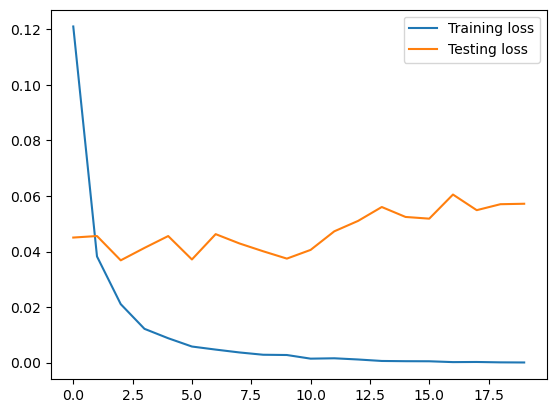

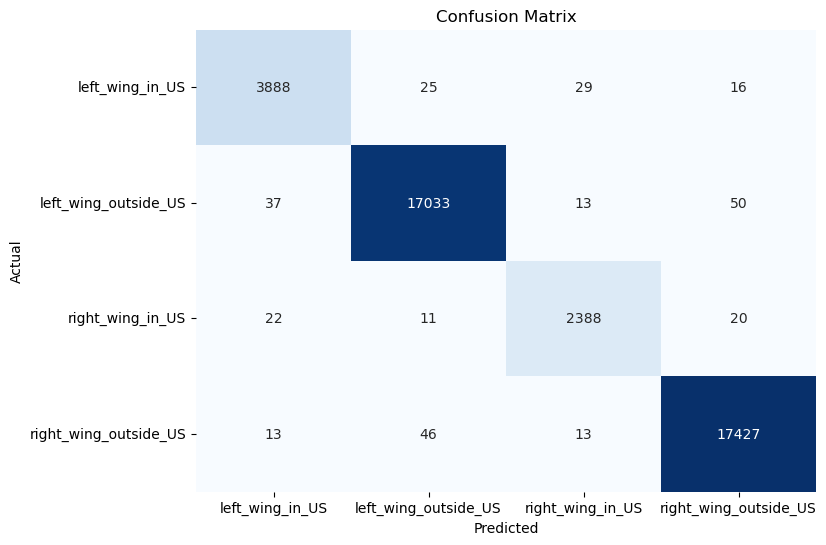

In [9]:
print(save_model_path(get_multimodal_model_save_location(nlp_model_path, image_model_path, fusion_mode)))
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(le.inverse_transform(true_labels), le.inverse_transform(predictions), digits=4))

# Training curves
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
del model
del test_data_loader
del train_data_loader

import gc         # garbage collect library
gc.collect()
torch.cuda.empty_cache() 

./trained_models/bart-large-cnn_beit-base-patch16-224-pt22k-ft22k_concat.pt
Accuracy: 0.9912992615339621
Classification Report:
                       precision    recall  f1-score   support

      left_wing_in_US     0.9815    0.9780    0.9798      3958
 left_wing_outside_US     0.9937    0.9933    0.9935     17133
     right_wing_in_US     0.9705    0.9689    0.9697      2441
right_wing_outside_US     0.9941    0.9954    0.9947     17499

             accuracy                         0.9913     41031
            macro avg     0.9849    0.9839    0.9844     41031
         weighted avg     0.9913    0.9913    0.9913     41031



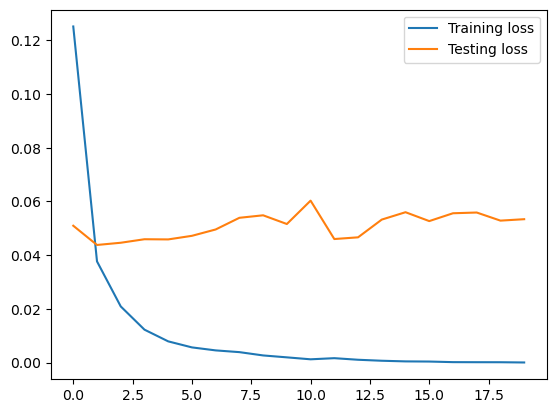

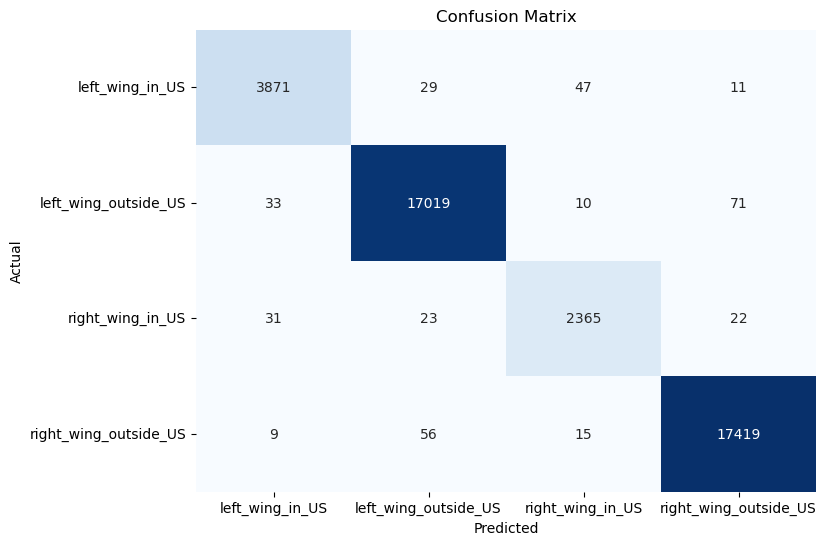

In [9]:
# tmp for results

./trained_models/bart-large-cnn_convnext-base-224-22k_add.pt
Accuracy: 0.9927128268869879
Classification Report:
                       precision    recall  f1-score   support

      left_wing_in_US     0.9780    0.9881    0.9830      3958
 left_wing_outside_US     0.9947    0.9945    0.9946     17133
     right_wing_in_US     0.9826    0.9717    0.9771      2441
right_wing_outside_US     0.9955    0.9949    0.9952     17499

             accuracy                         0.9927     41031
            macro avg     0.9877    0.9873    0.9875     41031
         weighted avg     0.9927    0.9927    0.9927     41031



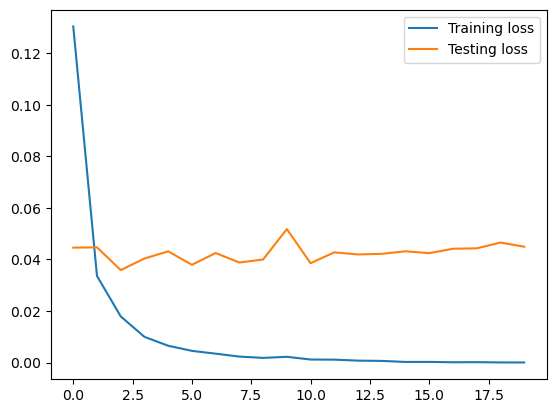

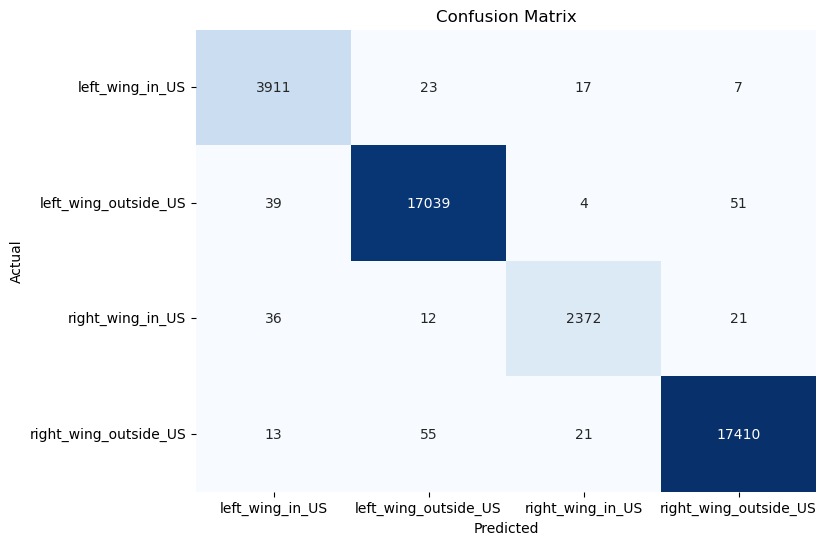

In [ ]:
# tmp hold for data

### Loading and evaluating trained models

In [ ]:
model = MMClassifier(len(le.classes_), nlp_model, image_model, fusion_mode, model_output_tensor_shape(image_model_path)).to(device)
model.load_state_dict(torch.load(save_model_path(get_multimodal_model_save_location(nlp_model_path, image_model_path, fusion_mode))))
model.eval()
print("")

In [ ]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in tqdm(test_data_loader):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    images = batch["image"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask, images)

    _, preds = torch.max(outputs, 1)
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

In [ ]:
print(save_model_path(get_multimodal_model_save_location(nlp_model_path, image_model_path, fusion_mode)))
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(le.inverse_transform(true_labels), le.inverse_transform(predictions), digits=4))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Whole dataset performance:

In [ ]:
if multimodal:
    model = MMClassifier(len(le.classes_), nlp_model, image_model, fusion_mode, model_output_tensor_shape(image_model_path)).to(device)
    model.load_state_dict(torch.load(save_model_path(get_multimodal_model_save_location(nlp_model_path, image_model_path, fusion_mode))))
    whole_dataset_loader = create_data_loader(
        data_subset['text'], encoded_labels, tokenizer, data_subset["id"], processor, MAX_LEN, BATCH_SIZE)
else:    
    model = NLPClassifier(len(le.classes_), base_model).to(device)
    model.load_state_dict(torch.load(
        save_model_path(get_model_save_location(model_path))))
    whole_dataset_loader = create_data_loader(
        data_subset['text'], encoded_labels, tokenizer, MAX_LEN, BATCH_SIZE)
model.eval()

In [ ]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in tqdm(whole_dataset_loader):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    images = batch["image"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask, images)

    _, preds = torch.max(outputs, 1)
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

In [ ]:
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(le.inverse_transform(
    true_labels), le.inverse_transform(predictions)))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Whole dataset performance for Roberta + ViT (concat):
```
Accuracy: 0.9932051044581144
Classification Report:
                       precision    recall  f1-score   support

      left_wing_in_US       0.97      0.99      0.98     19449
 left_wing_outside_US       1.00      1.00      1.00     85929
     right_wing_in_US       0.99      0.96      0.97     12161
right_wing_outside_US       1.00      1.00      1.00     87615

             accuracy                           0.99    205154
            macro avg       0.99      0.98      0.99    205154
         weighted avg       0.99      0.99      0.99    205154
```

In [ ]:
df_with_predictions = data_subset.copy()
df_with_predictions['predicted_classification'] = le.inverse_transform(predictions)

df_with_disagreeement = df_with_predictions[df_with_predictions['classification_by_editorial'] != df_with_predictions['predicted_classification']]
df_with_disagreeement

In [ ]:
if multimodal:
    path_in_predictions = get_multimodal_model_save_location(nlp_model_path, image_model_path, fusion_mode)
else:
    path_in_predictions = get_model_save_location(model_path)
    
isExist = os.path.exists('./predictions/')
if not isExist:
   os.makedirs('./predictions/')

df_with_disagreeement.to_csv('./predictions/' + path_in_predictions + '.csv')
# for each of the disagreements save each row as formatted json in a file in the folder predictions
isExist = os.path.exists('./predictions/' + path_in_predictions)
if not isExist:
   os.makedirs('./predictions/' + path_in_predictions)

for index, row in df_with_disagreeement.iterrows():
    with open('./predictions/' + path_in_predictions + '/' + str(row['id']) + '.json', 'w') as f:
        f.write(row.to_json())